In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np 
import matplotlib.pyplot as plt
import json
import os 
from PIL import Image

In [ ]:
tf.__version__

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TRAINING_FILENAMES = '../datasets/gazetrack_tfrec/train.tfrec'
VALID_FILENAMES = '../datasets/gazetrack_tfrec/val.tfrec'
TEST_FILENAMES = '../datasets/gazetrack_tfrec/test.tfrec'
BATCH_SIZE = 256

In [ ]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "device": tf.io.FixedLenFeature([], tf.string),
        "screen_h": tf.io.FixedLenFeature([], tf.int64),
        "screen_w": tf.io.FixedLenFeature([], tf.int64),
        "face_valid": tf.io.FixedLenFeature([], tf.int64),
        "face_x": tf.io.FixedLenFeature([], tf.int64),
        "face_y": tf.io.FixedLenFeature([], tf.int64),
        "face_w": tf.io.FixedLenFeature([], tf.int64),
        "face_h": tf.io.FixedLenFeature([], tf.int64),
        "leye_x": tf.io.FixedLenFeature([], tf.int64),
        "leye_y": tf.io.FixedLenFeature([], tf.int64),
        "leye_w": tf.io.FixedLenFeature([], tf.int64),
        "leye_h": tf.io.FixedLenFeature([], tf.int64),
        "reye_x": tf.io.FixedLenFeature([], tf.int64),
        "reye_y": tf.io.FixedLenFeature([], tf.int64),
        "reye_w": tf.io.FixedLenFeature([], tf.int64),
        "reye_h": tf.io.FixedLenFeature([], tf.int64),
        "dot_xcam": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_cam": tf.io.FixedLenFeature([], tf.float32),
        "dot_x_pix": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_pix": tf.io.FixedLenFeature([], tf.float32),
        "reye_x1": tf.io.FixedLenFeature([], tf.int64),
        "reye_y1": tf.io.FixedLenFeature([], tf.int64),
        "reye_x2": tf.io.FixedLenFeature([], tf.int64),
        "reye_y2": tf.io.FixedLenFeature([], tf.int64),
        "leye_x1": tf.io.FixedLenFeature([], tf.int64),
        "leye_y1": tf.io.FixedLenFeature([], tf.int64),
        "leye_x2": tf.io.FixedLenFeature([], tf.int64),
        "leye_y2": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

### Visualization

In [ ]:
raw_dataset = tf.data.TFRecordDataset(VALID_FILENAMES)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

# parsed_dataset
for features in parsed_dataset: 
    # for key in features.keys():
    #     if key != "image":
    #         print(f"{key}: {features[key]}")
    
    image = features['image']
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    w = tf.cast(w, tf.int64)
    h = tf.cast(h, tf.int64)
    
    screen_w, screen_h = features['screen_w'], features['screen_h']
    
    kps = [features['leye_x1']/w, features['leye_y1']/h, features['leye_x2']/w, features['leye_y2']/h,
           features['reye_x1']/w, features['reye_y1']/h, features['reye_x2']/w, features['reye_y2']/h]
    
    lx, ly, lw, lh = features['leye_x'], features['leye_y'], features['leye_w'], features['leye_h']
    rx, ry, rw, rh = features['reye_x'], features['reye_y'], features['reye_w'], features['reye_h']
    
    lx = tf.cast(lx, tf.int32)
    ly = tf.cast(ly, tf.int32)
    lw = tf.cast(lw, tf.int32)
    lh = tf.cast(lh, tf.int32)
    
    rx = tf.cast(rx, tf.int32)
    ry = tf.cast(ry, tf.int32)
    rw = tf.cast(rw, tf.int32)
    rh = tf.cast(rh, tf.int32)
    
    
    
    tf.print(lx, ly, lw, lh)
    tf.print(rx, ry, rw, rh)

In [22]:
def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False  # disable order, increase speed
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=AUTO)
  
    return dataset

def get_batched_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTO)
    return dataset

  
    
def get_training_dataset():
    return get_batched_dataset(training_filenames)

def get_validation_dataset():
    return get_batched_dataset(validation_filenames)

In [23]:
train_dataset = get_batched_dataset(TRAINING_FILENAMES)
valid_dataset = get_batched_dataset(VALID_FILENAMES)
test_dataset = get_batched_dataset(TEST_FILENAMES)

In [38]:
train_len = sum(1 for _ in tf.data.TFRecordDataset(TRAINING_FILENAMES))
val_len = sum(1 for _ in tf.data.TFRecordDataset(VALID_FILENAMES))
test_len = sum(1 for _ in tf.data.TFRecordDataset(TEST_FILENAMES))

print(f"No. of train samples: {train_len}")
print(f"No. of val samples: {val_len}")
print(f"No. of test samples: {test_len}")

No. of train samples: 398654
No. of val samples: 43458
No. of test samples: 59563


device: b'iPhone 5'
dot_x_pix: 160.0
dot_xcam: 0.0
dot_y_cam: -9.467451095581055
dot_y_pix: 528.0
face_h: 349
face_valid: 1
face_w: 349
face_x: 41
face_y: 257
leye_h: 105
leye_w: 105
leye_x: 200
leye_x1: 244
leye_x2: 294
leye_y: 343
leye_y1: 389
leye_y2: 392
path: b'/localscratch/sheenu22.29554065.0/gazetrack/train/images/00102__00052.jpg'
reye_h: 105
reye_w: 105
reye_x: 79
reye_x1: 120
reye_x2: 168
reye_y: 348
reye_y1: 391
reye_y2: 388
screen_h: 568
screen_w: 320
Image shape: (640, 480, 3)


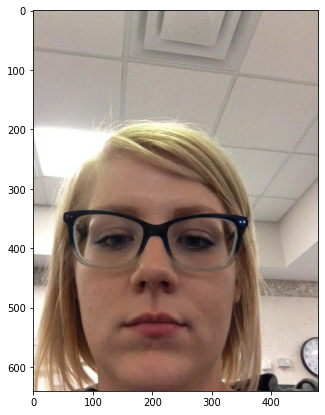

device: b'iPhone 6'
dot_x_pix: 232.00721740722656
dot_xcam: 1.7583125829696655
dot_y_cam: -3.3135364055633545
dot_y_pix: 160.93490600585938
face_h: 369
face_valid: 1
face_w: 369
face_x: 48
face_y: 271
leye_h: 111
leye_w: 111
leye_x: 255
leye_x1: 291
leye_x2: 354
leye_y: 300
leye_y1: 357
leye_y2: 349
path: b'/localscratch/sheenu22.29554065.0/gazetrack/train/images/00121__00083.jpg'
reye_h: 111
reye_w: 111
reye_x: 105
reye_x1: 139
reye_x2: 202
reye_y: 306
reye_y1: 360
reye_y2: 361
screen_h: 667
screen_w: 375
Image shape: (640, 480, 3)


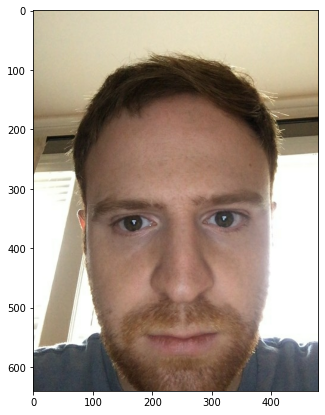

In [34]:
for features in train_dataset.take(2): #reading first 1 values from the dataset
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key][255]}")

    print(f"Image shape: {features['image'][255].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"][255].numpy())
    plt.show()